# Modelo lineal 

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
print(sys.executable)

/mnt/d/zrive-ds/.venv/bin/python


### 0. Cargar y filtrar los datos

Recogemos sólo los de 5 elementos o más 

In [2]:
local_directory = "/mnt/d/zrive-ds/src/module_2/files_downloaded"
file = "feature_frame.csv"
final_directory = "/mnt/d/zrive-ds/src/module_3/data/feature_frame_filtered.csv"

file_path = os.path.join(local_directory, file)

df = pd.read_csv(file_path)

In [77]:
# Filter the DataFrame to include only rows where 'outcome' is 1 (product was bought)
df_bought = df[df['outcome'] == 1]

# Group by 'order_id' and count the number of products bought per order
order_counts = df_bought.groupby('order_id').size()

# Filter orders with 5 or more products bought
orders_with_5_or_more = order_counts[order_counts >= 5].index

# Filter the original DataFrame to include only rows with these orders

filtered_df = df[df['order_id'].isin(orders_with_5_or_more)]

In [78]:
filtered_df.shape

(2163953, 27)

In [79]:
filtered_df.to_csv(final_directory, index=False)

## 1. Preparación de los datos

Cargamos los datos, separamos las columnas y creamos los df dde entrenamiento, validación y test

In [3]:
final_directory = "/mnt/d/zrive-ds/src/module_3/data/feature_frame_filtered.csv"
df = pd.read_csv(final_directory)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163953 entries, 0 to 2163952
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [83]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


Vamos con el modelo: tenemos que seleccionar las variables que pueden estar correladas con outcome wtf y practicar con ellas? El outcome es la variable que tenemos que predecir entiendo

Escribir el modelo, ver errores, elegir parametros y modelo, tomar el mejor practicando también con el dataset de validación.

In [8]:
df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [4]:
# List of numeric columns (you can adjust this list based on your data)
information_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]

target_col = ["outcome"]

binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]

label_cols = ["vendor", "product_type"]

numeric_cols = [col for col in df.columns.tolist() if col not in set(information_cols + binary_cols + label_cols + target_col)]

El split hay que hacerlo consistente. 

En primer lugar las ordenes tienen que estar juntas en el mismo grupo.

Si puede ser los usuarios también 
Si puede ser tiene que ser cronológico porque en el periodo cambian las dinámicas de los usuarios.

Si lo hago por fecha seguro que tengo en el mismo grupo la misma orden siempre! lo de users a la porra al final

In [5]:
# Sort the DataFrame by 'order_date'
df_sorted = df.sort_values(by='order_date')

# Calculate the number of unique orders
total_orders = df_sorted['order_id'].nunique()

# Determine the number of orders for each split
train_orders_count = int(total_orders * 0.7)
validation_orders_count = int(total_orders * 0.2)

# Split the sorted DataFrame into train, validation, and test sets based on order counts
train_df = df_sorted[df_sorted['order_id'].isin(df_sorted['order_id'].unique()[:train_orders_count])]
validation_df = df_sorted[df_sorted['order_id'].isin(df_sorted['order_id'].unique()[train_orders_count:train_orders_count + validation_orders_count])]
test_df = df_sorted[df_sorted['order_id'].isin(df_sorted['order_id'].unique()[train_orders_count + validation_orders_count:])]

print(f"Train set size: {train_df.shape}")
print(f"Validation set size: {validation_df.shape}")
print(f"Test set size: {test_df.shape}")


Train set size: (1446691, 27)
Validation set size: (466762, 27)
Test set size: (250500, 27)


In [6]:
X_train = train_df.drop("outcome", axis = 1)
y_train = train_df["outcome"]

X_validation = validation_df.drop("outcome", axis = 1)
y_validation = validation_df["outcome"]

X_test = test_df.drop("outcome", axis = 1)
y_test = test_df["outcome"]

## 2. Baselines

### 2.1 Baseline de popularidad

Tenemos la función que plotea las curvas que nos interesan.

Lo usamos para un modelo que sólo toma la popularidad como variable explicativa de outcome.

In [7]:
def plot_metrics(
    model_name: str,
    y_pred: pd.Series,
    y_test: pd.Series,
    target_precision: float = 0.05,
    figure = None,
):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1,2,figsize=(14,7))
    else:
        fig, ax = figure 

    ax[0].plot(recall, precision, label=f"{model_name}; AUC: {pr_auc:2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label = f"{model_name}; AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

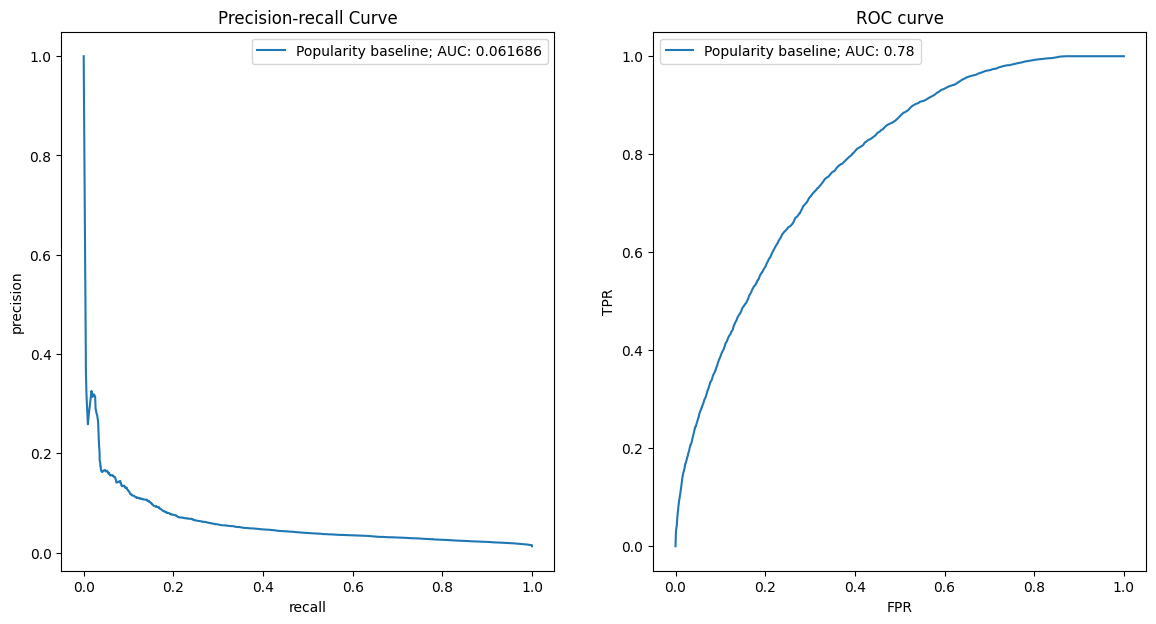

In [8]:
plot_metrics("Popularity baseline", y_pred=X_test["global_popularity"], y_test=y_test)

### 2.2. Baseline lineal

Cogemos de la matriz de correlaciones del EDA del modulo 2. Los más correlacionados con outcome son ordered_before, abandoned_before, global_popularity y set_as_regular y vamos a entrenar un modelo lineal para probar como funciona. 

In [9]:
features = ["ordered_before", "abandoned_before", "global_popularity", "set_as_regular"]

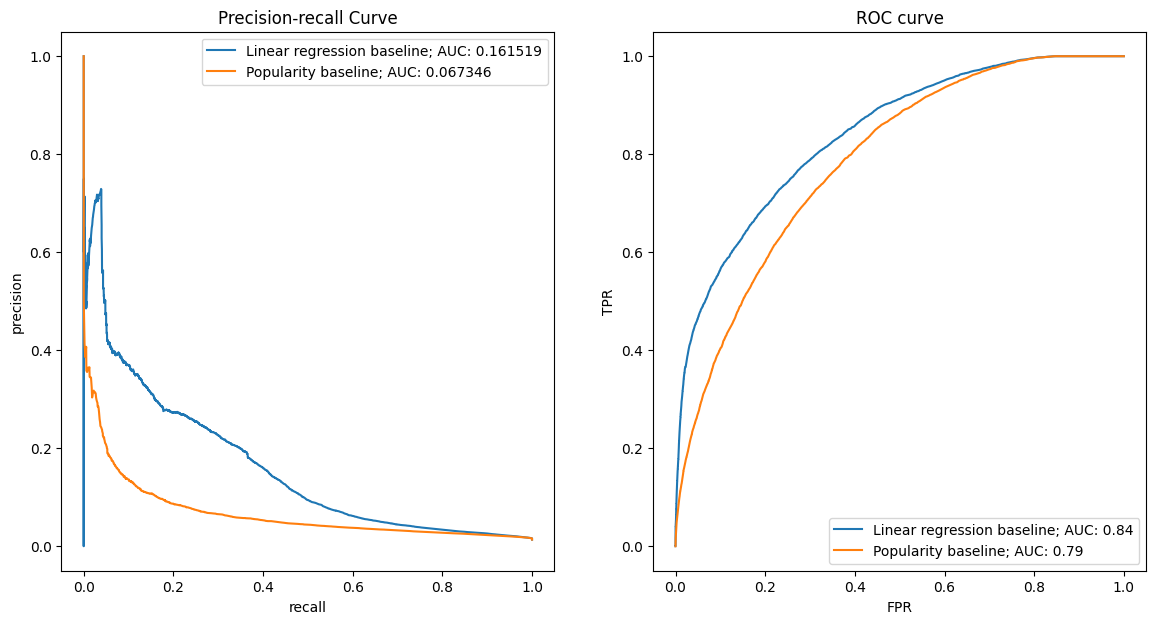

In [23]:
X_train_linear = X_train[features]

# Initialize the model
model = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

# Train the model on the training data
model.fit(X_train_linear, y_train)

X_validation_linear = X_validation[features]
y_validation_pred_linear = model.predict(X_validation_linear)

y_train_pred_linear = model.predict(X_train_linear)

fig1, ax1 = plt.subplots(1,2,figsize = (14,7))

plot_metrics("Linear regression baseline",y_pred=y_validation_pred_linear, y_test=y_validation, figure = (fig1, ax1))
plot_metrics("Popularity baseline", y_pred=X_validation["global_popularity"], y_test=y_validation, figure = (fig1, ax1))


El modelo lineal con 4 features funciona mejor en todos los puntos que el popularity por lo que podría ser un buen baseline a batir a partir de ahora. 

## 3. Modelos 

Uso pipeline como guille estuvo explicando en la clase anterior. 

Además como features amplio y dejo que el modelo use todas las numéricas (también binarias).


In [11]:
columns_train = binary_cols + numeric_cols

### 3.1. Ridge

El pipeline lo usamos para normalizar los datos dado que al principio tuvimos un problema de convergencia sin hacerlo y a veces me daba error. 

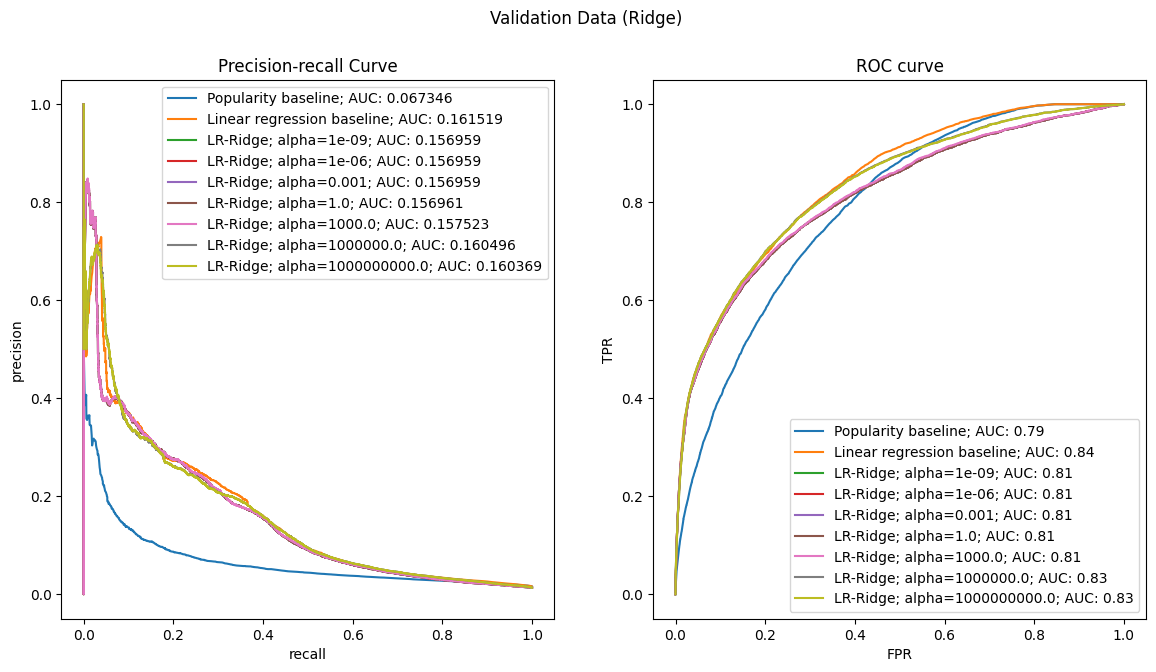

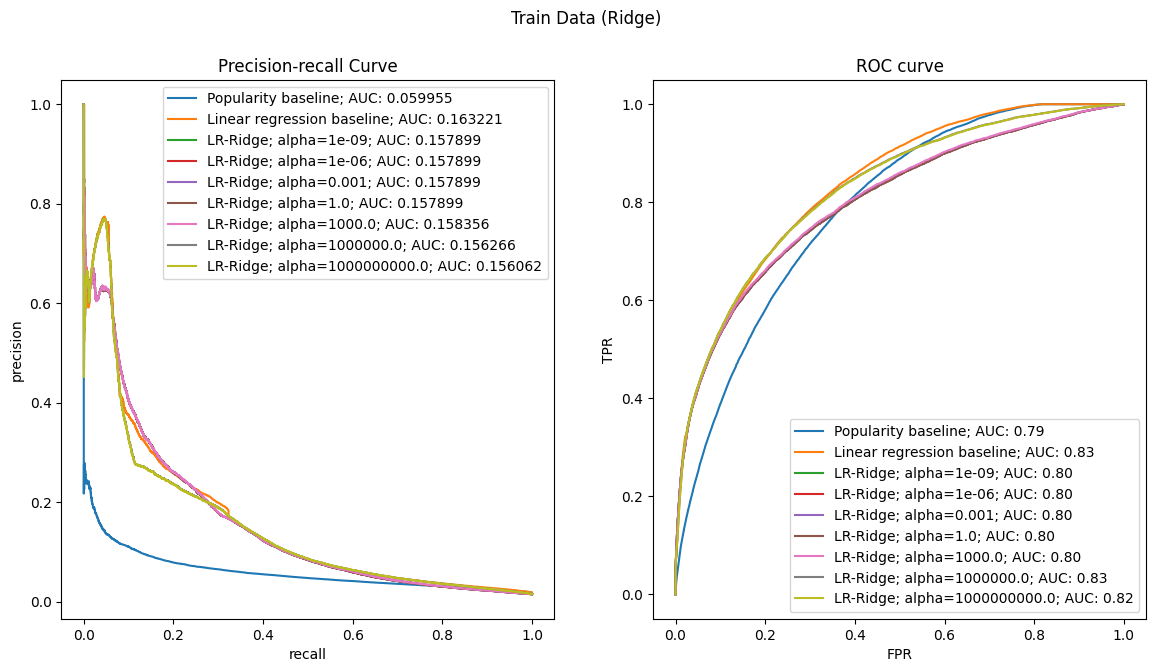

In [14]:
fig2, ax2 = plt.subplots(1,2,figsize = (14,7))
fig2.suptitle("Validation Data (Ridge)")
fig3, ax3 = plt.subplots(1,2,figsize = (14,7))
fig3.suptitle("Train Data (Ridge)")
alphas = alphas = np.logspace(-9, 9, 7)

plot_metrics("Popularity baseline", y_pred=X_validation["global_popularity"], y_test=y_validation, figure = (fig2, ax2))
plot_metrics("Linear regression baseline",y_pred=y_validation_pred_linear, y_test=y_validation, figure = (fig2, ax2))
plot_metrics("Popularity baseline", y_pred=X_train["global_popularity"], y_test=y_train, figure = (fig3, ax3))
plot_metrics("Linear regression baseline",y_pred=y_train_pred_linear, y_test=y_train, figure = (fig3, ax3))
for alpha in alphas: 
    c = 1/alpha

    model_ridge_LR = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C = c)
    )

    model_ridge_LR.fit(X_train[columns_train], y_train)

    y_pred_ridge = model_ridge_LR.predict_proba(X_validation[columns_train])[:, 1] # Probabilidad de la clase positiva
    
    if alpha == 1e6: #los guardamos aquí por comodidad para usarlo más adelante
        ridge_coefficients = model_ridge_LR.named_steps['logisticregression'].coef_[0]

    plot_metrics(
        f"LR-Ridge; alpha={alpha}", y_pred = y_pred_ridge, y_test = y_validation, figure = (fig2, ax2)
    )

    y_pred_ridge = model_ridge_LR.predict_proba(X_train[columns_train])[:, 1]
    plot_metrics(
        f"LR-Ridge; alpha={alpha}", y_pred = y_pred_ridge, y_test = y_train, figure = (fig3, ax3)
    )


Los distintos parámetros no parecen batir el modelo lineal (OLS) baseline en ningún punto en particupar de la curva (Además de tener un AUC similar, incluso algo menor). No estaría en principio muy justificado estar usando estos modelos más "complejos" pues no hay mejoras en los datos de validación ni en los de test. Vemos que los errores de entrenamiento y validación son parecidos por lo que no habría signos de overfitting.  

### 3.2. Lasso

/mnt/d/zrive-ds/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


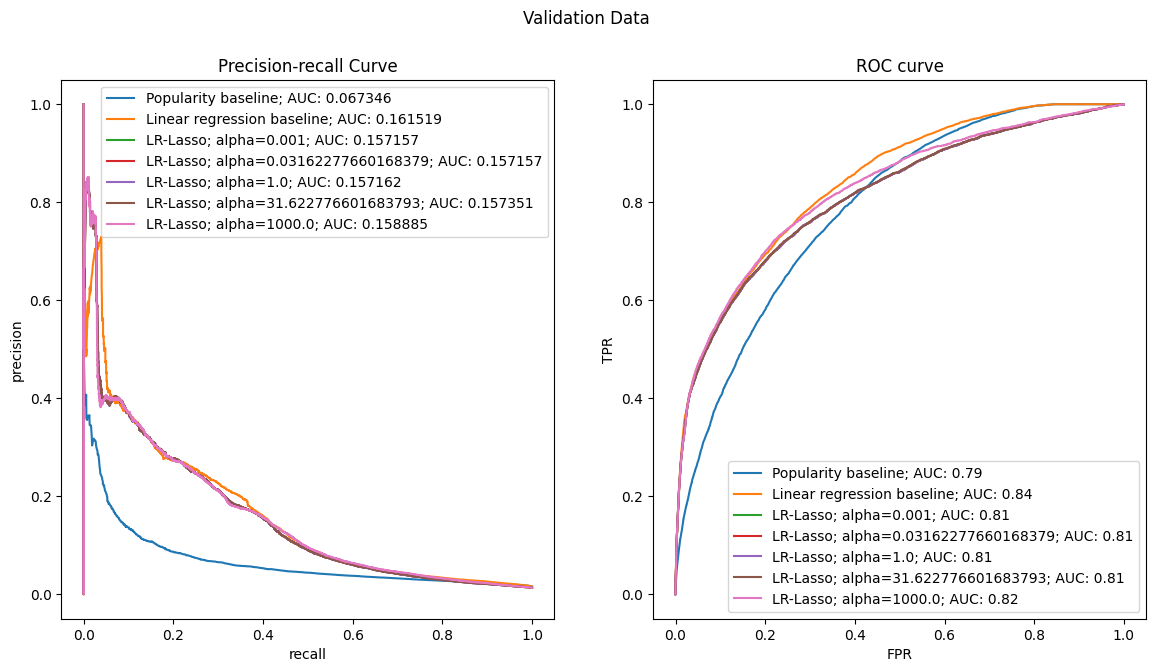

/mnt/d/zrive-ds/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


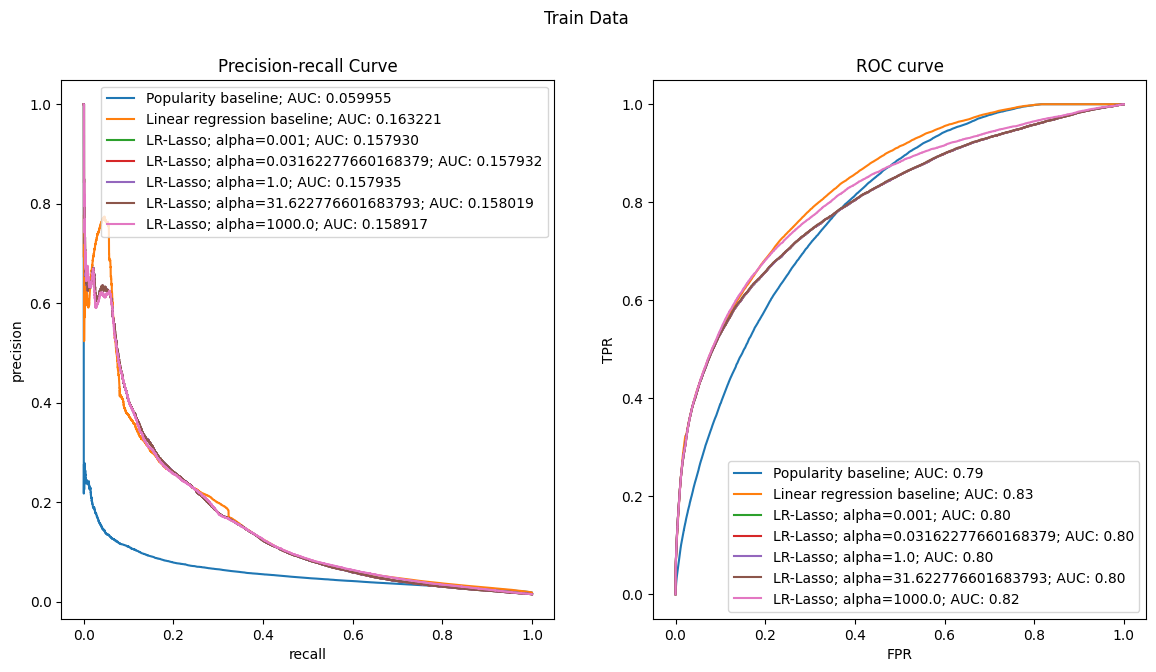

In [22]:
fig4, ax4 = plt.subplots(1,2,figsize = (14,7))
fig4.suptitle("Validation Data")
fig5, ax5 = plt.subplots(1,2,figsize = (14,7))
fig5.suptitle("Train Data")
alphas = alphas = np.logspace(-3, 3, 5)

plot_metrics("Popularity baseline", y_pred=X_validation["global_popularity"], y_test=y_validation, figure = (fig4, ax4))
plot_metrics("Linear regression baseline",y_pred=y_validation_pred_linear, y_test=y_validation, figure = (fig4, ax4))
plot_metrics("Popularity baseline", y_pred=X_train["global_popularity"], y_test=y_train, figure = (fig5, ax5))
plot_metrics("Linear regression baseline",y_pred=y_train_pred_linear, y_test=y_train, figure = (fig5, ax5))
for alpha in alphas: 
    c = 1/alpha

    model_lasso_LR = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", C = c, solver='saga')
    )

    model_lasso_LR.fit(X_train[columns_train], y_train)

    y_pred_lasso = model_lasso_LR.predict_proba(X_validation[columns_train])[:, 1] # Probabilidad de la clase positiva
    
    if alpha == 1e3: #los guardamos aquí por comodidad para usarlo más adelante
        lasso_coefficients = model_lasso_LR.named_steps['logisticregression'].coef_[0]

    plot_metrics(
        f"LR-Lasso; alpha={alpha}", y_pred = y_pred_lasso, y_test = y_validation, figure = (fig4, ax4)
    )

    y_pred_lasso = model_lasso_LR.predict_proba(X_train[columns_train])[:, 1]
    plot_metrics(
        f"LR-Lasso; alpha={alpha}", y_pred = y_pred_lasso, y_test = y_train, figure = (fig5, ax5)
    )


Tampoco encontramos indicios de un mejor modelo usando aquí la regresión logistica. Tampoco hay indicios de overfitting (mismos errores de validación y entrenamiento). 

Vemos que feature selection está haciendo Lasso (en principio debería coincidir más o menos con las del modelo lineal, popularity, set as regular, abandoned before, etc). 

Además vemos los coeficientes de todas para poder comparar. Tomamos en ambos casos la regularización con alfa = 1 (lo hemos preparado antes) dado que para todas parecen parecidas. 

In [19]:
coefficients_OLS = model.coef_
lasso_coefficients = model_lasso_LR.named_steps['logisticregression'].coef_[0]

##Aquí estamos cogiendo los del último, pero no el del alpha = 1. Eso lo podemos meter en el código de arriba para que en el 1 pare y haga también lo de guardar los coeficientes. 

# Se han usado distintas features
ols_df = pd.DataFrame({
    'Feature': features,
    'OLS Coefficient': coefficients_OLS
})

lasso_ridge_df = pd.DataFrame({
    'Feature': columns_train,
    'Lasso Coefficient': lasso_coefficients,
    'Ridge Coefficient': ridge_coefficients
})

merged_df = pd.merge(ols_df, lasso_ridge_df, on='Feature', how='outer')
merged_df.fillna(0, inplace=True)

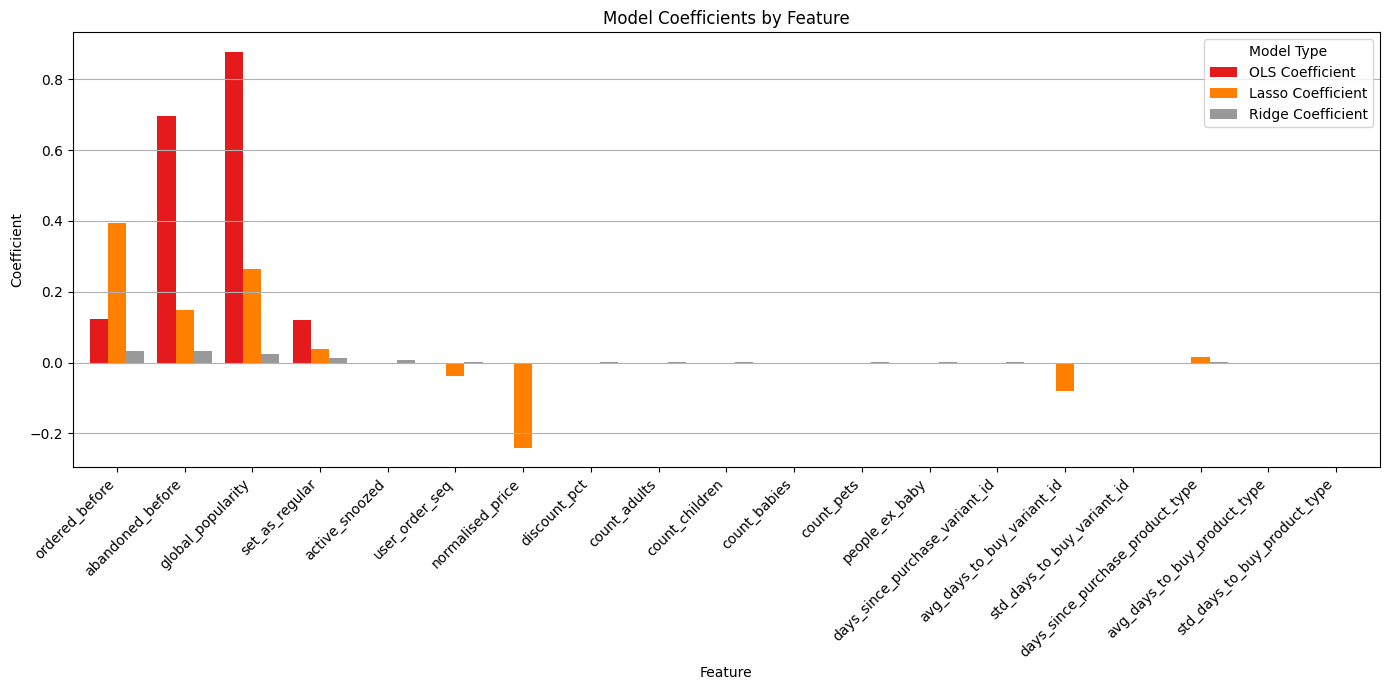

In [20]:

merged_df.set_index('Feature', inplace=True)
ax = merged_df.plot(kind='bar', figsize=(14, 7), colormap='Set1', width=0.8)
plt.title('Model Coefficients by Feature')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.grid(axis='y')
plt.tight_layout()

Como pensabamos, Lasso da valores mayores a las variables que ya estabamos usando en nuestro baseline lineal, y que habíamos obtenido de la matriz de covarianzas del EDA. Ridge también les da valores relevantes a estas aunque también a muchas otras, que Lasso lleva a cero (feature selection). 
En principio no podemos ver si estos modelos pueden ser más complejos que el lineal con las cuatro variables elegidas viendo las correlaciones, aunque tampoco tienen un peor desempeño.

## 3.3. Categorical Encoding

Pruebo ahora a usar las features que había descartado desde el principio por no ser numéricas. Me baso en frequency encoding y ordinal encoding para no utilizar otros métodos que me aumenten demasiado la cardinalidad del dataset como onehot encoding. 

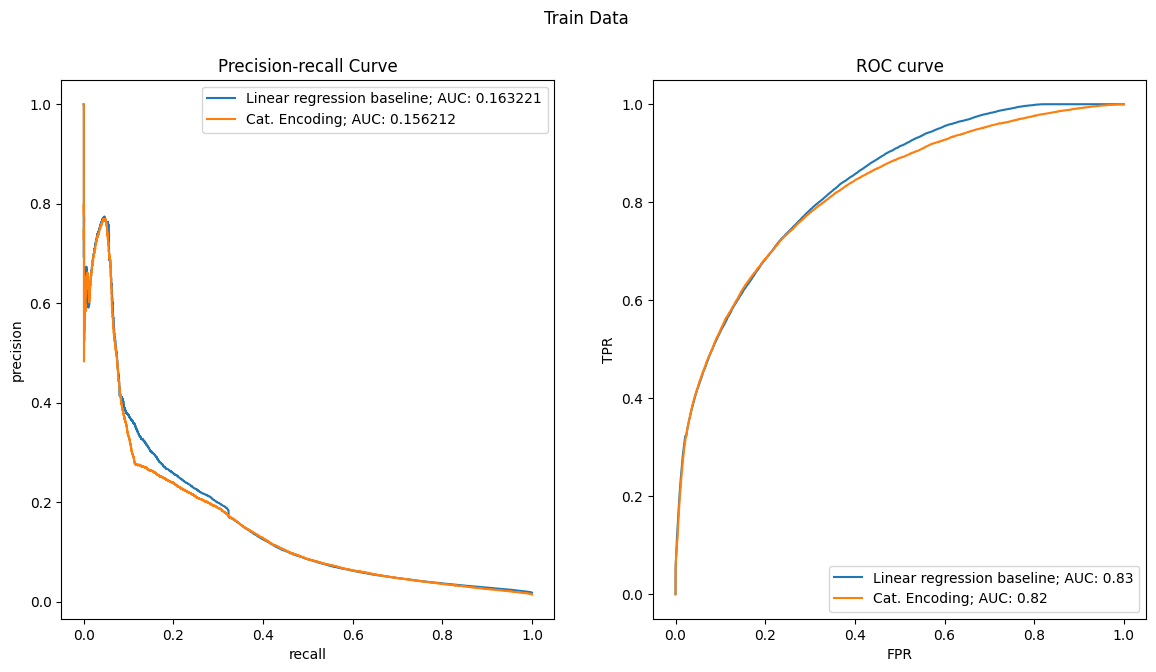

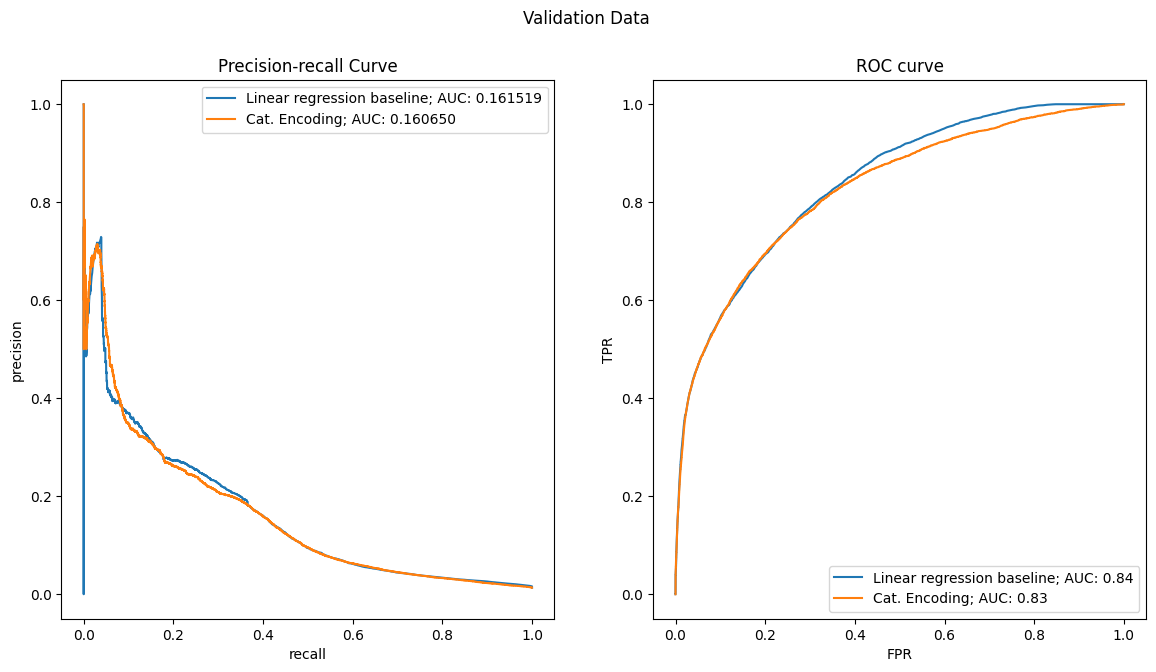

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

cols_cat_enc = columns_train + label_cols

fig6, ax6 = plt.subplots(1,2,figsize = (14,7))
fig7, ax7 = plt.subplots(1,2,figsize = (14,7))
fig6.suptitle("Train Data")
fig7.suptitle("Validation Data")
plot_metrics("Linear regression baseline",y_pred=y_validation_pred_linear, y_test=y_validation, figure = (fig7, ax7))
plot_metrics("Linear regression baseline",y_pred=y_train_pred_linear, y_test=y_train, figure = (fig6, ax6))

categorical_processors = [
    OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1),
]
alpha = 1e6
for cat_processor in categorical_processors:
    preporcessor = ColumnTransformer(
        [
            ("numerical", "passthrough", columns_train),
            ("categorical", cat_processor, label_cols),
        ]
    )
    model_CE = make_pipeline(
        preporcessor,
        StandardScaler(),
        LogisticRegression(penalty = "l2", C = 1/alpha)
    )

    model_CE.fit(X_train[cols_cat_enc], y_train)

    y_pred_CE = model_CE.predict_proba(X_train[cols_cat_enc])[:, 1]
    plot_metrics("Cat. Encoding", y_pred = y_pred_CE, y_test = y_train, figure = (fig6, ax6))

    y_pred_CE = model_CE.predict_proba(X_validation[cols_cat_enc])[:, 1]
    plot_metrics("Cat. Encoding", y_pred = y_pred_CE, y_test = y_validation, figure = (fig7, ax7))



La predicción del modelo no mejora. En principio el modelo que estoy probando no es tan complejo como para capturar mejor relaciones que ya se estaban percibiendo con los modelos lineales, y aunque las categóricas puedan aportar información, apenas la está aprovechando. En principio, podrían aportar más con modelos no lineales. 